In [1]:
#Import dataset from csv.
import pandas as pd
train_set=pd.read_csv('emnist-letters-train.csv').to_numpy()
test_set =pd.read_csv('emnist-letters-test.csv').to_numpy()


In [ ]:
train_set.shape

(88799, 785)

In [2]:
#split up the labels
y = train_set[:, 0]
X = train_set[:, 1:]
#split up into validation set --> 20% for validation
X_valid,X_train = X[:17500], X[17500:]
y_valid,y_train = y[:17500], y[17500:]

In [ ]:
test_y = test_set[:, 0]
test_X = test_set[:, 1:]
X_test = test_X
y_test = test_y

Hyper tuning

In [3]:
#imports for Keras_tuner
import sys

if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.1 MB/s eta 0:00:00


In [4]:
import keras_tuner as kt
import tensorflow as tf
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=400)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(27, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [5]:
# Use KerasTuner RandomSearch to tune hyperparameters
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=30, overwrite=True,
    directory="my_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=20,
                           validation_data=(X_valid, y_valid))

Trial 30 Complete [00h 06m 25s]
val_accuracy: 0.8510857224464417

Best val_accuracy So Far: 0.8813714385032654
Total elapsed time: 02h 15m 56s


In [6]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 17 summary
Hyperparameters:
n_hidden: 8
n_neurons: 226
learning_rate: 0.0033137745378583987
Score: 0.8813714385032654


In [7]:
best_trial.metrics.get_last_value("val_accuracy")

0.8813714385032654

In [8]:
best_trial.metrics.get_last_value("accuracy")

0.9423834681510925

In [20]:
best_model = random_search_tuner.get_best_models(num_models=1)[0]
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

463/463 [==============================] - 6s 10ms/step - loss: 0.4873 - accuracy: 0.8645


Manual model building

In [35]:
import keras
model = keras.models.Sequential()

#model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.InputLayer(input_shape=[784]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(27, activation="softmax"))

In [36]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])


In [37]:
#Callbacks
#stops the training if val_accuracy doesn't improve in 10 epochs
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

Train the model

In [38]:
#Fit the model on train_set, validation set used as validation_data
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), callbacks=[early_stopping])

Epoch 1/30
2229/2229 [==============================] - 19s 8ms/step - loss: 2.1891 - accuracy: 0.4847 - val_loss: 0.9521 - val_accuracy: 0.7090
Epoch 2/30
2229/2229 [==============================] - 19s 9ms/step - loss: 0.7868 - accuracy: 0.7628 - val_loss: 0.6623 - val_accuracy: 0.7955
Epoch 3/30
2229/2229 [==============================] - 17s 8ms/step - loss: 0.5982 - accuracy: 0.8162 - val_loss: 0.6091 - val_accuracy: 0.8245
Epoch 4/30
2229/2229 [==============================] - 17s 8ms/step - loss: 0.5158 - accuracy: 0.8421 - val_loss: 0.5532 - val_accuracy: 0.8355
Epoch 5/30
2229/2229 [==============================] - 17s 8ms/step - loss: 0.4605 - accuracy: 0.8574 - val_loss: 0.5328 - val_accuracy: 0.8419
Epoch 6/30
2229/2229 [==============================] - 18s 8ms/step - loss: 0.4229 - accuracy: 0.8670 - val_loss: 0.5150 - val_accuracy: 0.8504
Epoch 7/30
2229/2229 [==============================] - 19s 8ms/step - loss: 0.3835 - accuracy: 0.8793 - val_loss: 0.4978 - val_ac

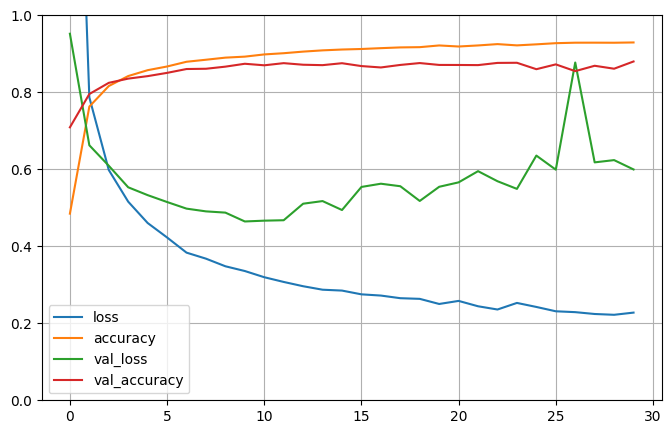

In [39]:
#graphically shows metrics
%matplotlib inline
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Evaluating the manual model

In [40]:
#evaluating on the test set
model.evaluate(X_test, y_test)

463/463 [==============================] - 1s 3ms/step - loss: 0.6371 - accuracy: 0.8638


[0.637067973613739, 0.8637745976448059]